Parameters: L=10.0, N=16 (lambda=1.6), M=4, c=3.0
Analytic (gamma renewal) probability: 0.2166
Simulated probability (over 100000 trials): 0.0789


100%|██████████| 50/50 [00:07<00:00,  6.68it/s]


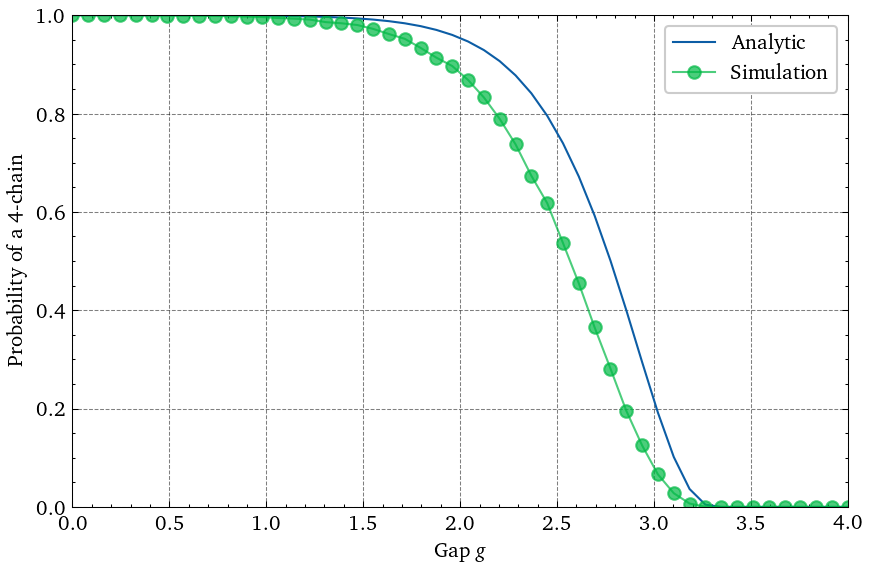

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
plt.style.use(['science', 'grid'])

plt.rcParams['text.latex.preamble'] = r'''
    \usepackage[T1]{fontenc}
    \usepackage{XCharter}
    \usepackage[charter,vvarbb,scaled=1.05]{newtxmath}
'''

def has_chain(points, c, M):
    """
    Given a sorted array `points`, checks if there exists a chain of M points
    such that each successive point is at least c apart (using a greedy algorithm).
    """
    if len(points) == 0:
        return False
    count = 1  # always take the first point
    current = points[0]
    for p in points:
        if p >= current + c:
            count += 1
            current = p
            if count >= M:
                return True
    return False

def simulate_chain_probability(L, lam, M, c, num_trials=100000):
    """
    Simulate a Poisson process on [0,L] with rate lam (so mean number = lam*L),
    and compute the fraction of trials in which a chain of M points with gap >= c exists.
    """
    successes = 0
    for _ in range(num_trials):
        # Number of points is Poisson distributed with mean lam*L.
        n_points = np.random.poisson(lam * L)
        # Generate points uniformly on [0, L] and sort them.
        points = np.sort(np.random.uniform(0, L, n_points))
        if has_chain(points, c, M):
            successes += 1
    return successes / num_trials

def analytic_chain_probability(L, lam, M, c):
    """
    The renewal-process (Poisson process) approximation:
    We view the chain as starting at some point and then requiring M-1 gaps.
    Each gap is modeled as R = c + Exp(lam). The total additional waiting time is:
       S = (M-1)*c + Y, where Y ~ Gamma(M-1, rate=lam).
    For a chain to fit in [0,L] (ignoring where the chain starts), we require
       Y <= L - (M-1)*c.
    Thus the analytic probability is approximated by the Gamma CDF:
       P = GammaCDF( L - (M-1)*c; shape=M-1, scale=1/lam )
    Note: if L < (M-1)*c then P is zero.
    """
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

# Parameters for the experiment:
L = 10.0          # Length of the interval.
N = 16            # "Target" number of points (on average).
lam = N / L       # Poisson rate.
M = 4             # Desired chain length.
c = 3.0           # Minimum gap between consecutive points in the chain.

# Compute analytic probability:
analytic_prob = analytic_chain_probability(L, lam, M, c)

# Run simulation:
num_trials = 100000
sim_prob = simulate_chain_probability(L, lam, M, c, num_trials)

print(f"Parameters: L={L}, N={N} (lambda={lam}), M={M}, c={c}")
print(f"Analytic (gamma renewal) probability: {analytic_prob:.4f}")
print(f"Simulated probability (over {num_trials} trials): {sim_prob:.4f}")

# Optionally, compare probabilities for a range of c values.
cs = np.linspace(0, L/(M-1)*1.2, 50)  # vary c from 0 to a bit above the maximum possible gap.
sim_probs = [simulate_chain_probability(L, lam, M, c_val, num_trials=20000) for c_val in tqdm(cs)]
analytic_probs = [analytic_chain_probability(L, lam, M, c_val) for c_val in cs]

plt.figure(dpi=150, figsize=(6, 4))
plt.plot(cs, analytic_probs, label="Analytic")
plt.plot(cs, sim_probs, 'o-', label="Simulation", alpha=0.7)
plt.xlabel("Gap $g$")
plt.ylabel(f"Probability of a {M}-chain")
# plt.title(f"Probability of a {M}-chain ($L$={L}, $N$={N}, $M$={M})")
plt.ylim(0, 1)
plt.xlim(0, cs[-1])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("chain_probability.pdf")
plt.show()


In [ ]:
# Should probably analytically derive an error bound? Or just draw a heatmap